## Overview

This analysis assumes 1 plant per image, with plant images already cropped and background pixels removed. K-means clustering with $k = 10$ has been applied to assign each pixel to the nearest cluster. This produces a data frame with $n <= 9$ rows per plant (the cluster consisting of masked background pixels is always omitted). Each row $n$ corresponds to the $n$'th most common color cluster, with colors in RGB, HSV, and hexadecimal encodings, along with the number of pixels belonging to a cluster and the proportion of total pixels that number represents.

## Data preparation

### Loading the data

Begin by loading data from CSV.

In [1]:
import pandas as pd

df = pd.read_csv('../data_sarracenia/tabular/masked.colors.csv', index_col=0)
df

Image      Hex         R  \
0     data_sarracenia/masked/10_14_19.10_30_20.f102-...  #95962f  0.584314   
1     data_sarracenia/masked/10_14_19.10_30_20.f102-...  #a16a3d  0.631373   
2     data_sarracenia/masked/10_14_19.10_30_20.f102-...  #883a22  0.533333   
3     data_sarracenia/masked/10_14_19.10_30_20.f102-...  #825a2b  0.509804   
4     data_sarracenia/masked/10_14_19.10_30_20.f102-...  #c4bb67  0.768627   
...                                                 ...      ...       ...   
8779  data_sarracenia/masked/9_6_18.Maxsea.r010.mask...  #3c2211  0.235294   
8780  data_sarracenia/masked/9_6_18.Maxsea.r010.mask...  #b08f80  0.690196   
8781  data_sarracenia/masked/9_6_18.Maxsea.r010.mask...  #996864  0.600000   
8782  data_sarracenia/masked/9_6_18.Maxsea.r010.mask...  #7c4644  0.486275   
8783  data_sarracenia/masked/9_6_18.Maxsea.r010.mask...  #201009  0.125490   

             G         B         H         S         V    Freq      Prop  
0     0.588235  0.184314  0.168285  0.686667  0.588235  253104  0.099263  
1     0.415686  0.239216  0.075000  0.621118  0.631373  331614  0.130053  
2     0.227451  0.133333  0.039216  0.750000  0.533333  183669  0.072032  
3     0.352941  0.168627  0.090038  0.669231  0.509804  339249  0.133047  
4     0.733333  0.403922  0.150538  0.474490  0.768627  236682  0.092822  
...        ...       ...       ...       ...       ...     ...       ...  
8779  0.133333  0.066667  0.065891  0.716667  0.235294  225010  0.197028  
8780  0.560784  0.501961  0.052083  0.272727  0.690196   59631  0.052215  
8781  0.407843  0.392157  0.012579  0.346405  0.600000   75363  0.065991  
8782  0.274510  0.266667  0.005952  0.451613  0.486275  114237  0.100031  
8783  0.062745  0.035294  0.050725  0.718750  0.125490  210928  0.184697  

[8784 rows x 10 columns]

#### Cleaning the data

Next we clean up the data and parse filenames for date, treatment, and plant label. We assume 1 image per plant, with filename following the format `[date][treatment][name].[extension]`. The date must be in format `%M-%D-%Y`.

In [2]:
from pytcherplants.utils import *

# extract date, treatment and name from image name
df['Date'] = pd.to_datetime(df.apply(row_date, axis=1).tolist(), format='%m_%d_%y')
df['Treatment'] = df.apply(row_treatment, axis=1)
df['Name'] = df.apply(row_name, axis=1)

# drop rows with unknowns (malformed filename format)
df.dropna(how='any', inplace=True)

df

Image      Hex         R  \
0     data_sarracenia/masked/10_14_19.10_30_20.f102-...  #95962f  0.584314   
1     data_sarracenia/masked/10_14_19.10_30_20.f102-...  #a16a3d  0.631373   
2     data_sarracenia/masked/10_14_19.10_30_20.f102-...  #883a22  0.533333   
3     data_sarracenia/masked/10_14_19.10_30_20.f102-...  #825a2b  0.509804   
4     data_sarracenia/masked/10_14_19.10_30_20.f102-...  #c4bb67  0.768627   
...                                                 ...      ...       ...   
8779  data_sarracenia/masked/9_6_18.Maxsea.r010.mask...  #3c2211  0.235294   
8780  data_sarracenia/masked/9_6_18.Maxsea.r010.mask...  #b08f80  0.690196   
8781  data_sarracenia/masked/9_6_18.Maxsea.r010.mask...  #996864  0.600000   
8782  data_sarracenia/masked/9_6_18.Maxsea.r010.mask...  #7c4644  0.486275   
8783  data_sarracenia/masked/9_6_18.Maxsea.r010.mask...  #201009  0.125490   

             G         B         H         S         V    Freq      Prop  \
0     0.588235  0.184314  0.168285  0.686667  0.588235  253104  0.099263   
1     0.415686  0.239216  0.075000  0.621118  0.631373  331614  0.130053   
2     0.227451  0.133333  0.039216  0.750000  0.533333  183669  0.072032   
3     0.352941  0.168627  0.090038  0.669231  0.509804  339249  0.133047   
4     0.733333  0.403922  0.150538  0.474490  0.768627  236682  0.092822   
...        ...       ...       ...       ...       ...     ...       ...   
8779  0.133333  0.066667  0.065891  0.716667  0.235294  225010  0.197028   
8780  0.560784  0.501961  0.052083  0.272727  0.690196   59631  0.052215   
8781  0.407843  0.392157  0.012579  0.346405  0.600000   75363  0.065991   
8782  0.274510  0.266667  0.005952  0.451613  0.486275  114237  0.100031   
8783  0.062745  0.035294  0.050725  0.718750  0.125490  210928  0.184697   

           Date Treatment        Name  
0    2019-10-14  10_30_20  f102-04049  
1    2019-10-14  10_30_20  f102-04049  
2    2019-10-14  10_30_20  f102-04049  
3    2019-10-14  10_30_20  f102-04049  
4    2019-10-14  10_30_20  f102-04049  
...         ...       ...         ...  
8779 2018-09-06    maxsea        r010  
8780 2018-09-06    maxsea        r010  
8781 2018-09-06    maxsea        r010  
8782 2018-09-06    maxsea        r010  
8783 2018-09-06    maxsea        r010  

[8784 rows x 13 columns]

## Scale conversion

Next we can load an image with a ruler for a reference scale, and calculate a conversion factor between pixels and standard/imperial units.

First load the image.

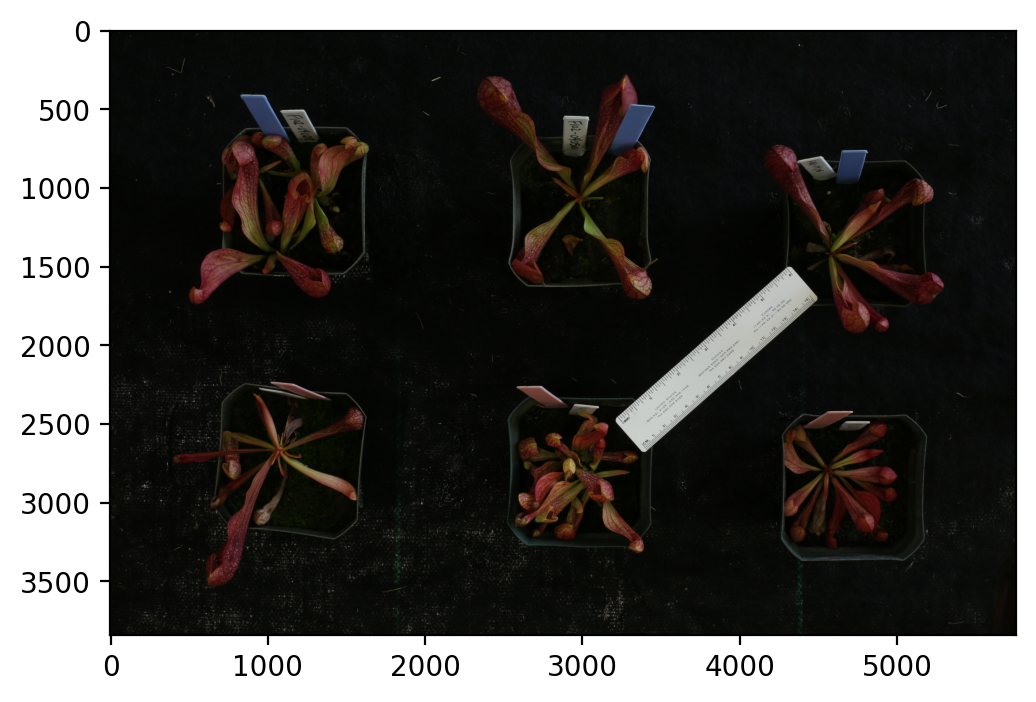

In [3]:
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams['figure.dpi'] = 200

scale = cv2.cvtColor(cv2.imread('../data_sarracenia/scale/ruler.jpg'), cv2.COLOR_RGB2BGR)
plt.imshow(scale)

Overlay a rectangle to measure scale.

/Users/wes/dev/pytcherplants/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


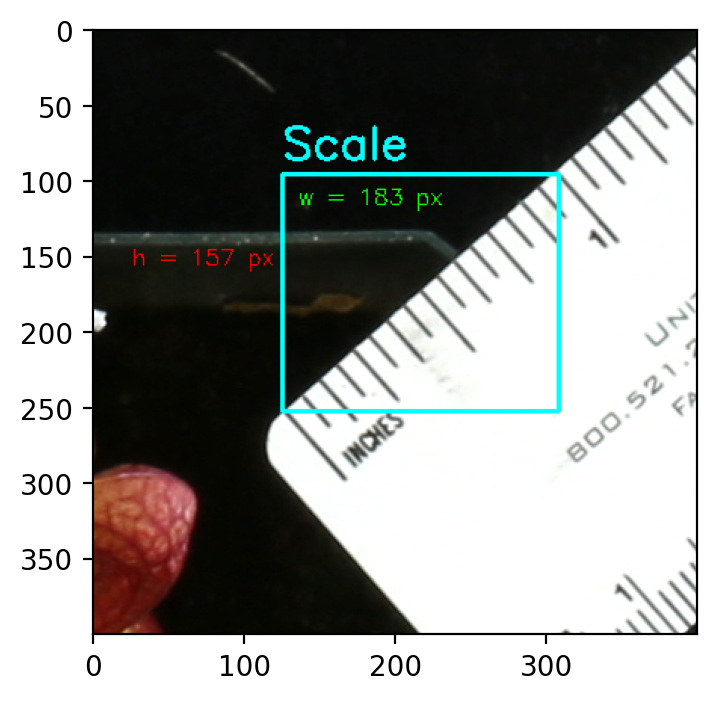

In [83]:
scale_copy = scale.copy()

# reduce image brightness
a = np.ones(scale_copy.shape, dtype=np.float) / 200
scale_copy = scale_copy * a

# define scaling box
x = 3225
y = 2295
w = 183
h = 157
cv2.rectangle(scale_copy, (x, y), (x + w, y + h), (0, 220, 50), 2)
cv2.putText(scale_copy,
            "Scale",
            (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.0,
            (0, 220, 50),
            2)
cv2.putText(scale_copy,
            f"w = {w} px",
            (x + 10, y + 20),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            1)
cv2.putText(scale_copy,
            f"h = {h} px",
            (x - 100, y + 60),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 0, 0),
            1)

# zoom in
cropped = scale_copy[2200:2600, 3100:3500]
plt.imshow(cropped)
plt.savefig('../data_sarracenia/scale/scale.jpg')
# cv2.imwrite('../data_sarracenia/scale.jpg', cropped)

Since $ a^2 + b^2 = c^2 $ we have a length conversion factor $ c =  \sqrt{ 157^2 + 183^2 } \approx 241.1182 $ pixels per inch. The area conversion is then $ 241.118228262^2 \approx 58138 $ pixels per square inch, and $ 58138 / 	6.4516 \approx 9011.408 $ pixels per square centimeter

**Conversion Factors**
- $241.1182 \text{ px} / \text{in}$
- $58138 \text{ px} / \text{in}^2$
- $9011.408 \text{ px} / \text{cm}^2$s

Now we can convert pixel counts to approximate area in square inches and centimeters.

In [5]:
df['SqIn'] = df['Freq'].astype(float) / 58138
df['SqCm'] = df['Freq'].astype(float) / 9011.408
df

Image      Hex         R  \
0     data_sarracenia/masked/10_14_19.10_30_20.f102-...  #95962f  0.584314   
1     data_sarracenia/masked/10_14_19.10_30_20.f102-...  #a16a3d  0.631373   
2     data_sarracenia/masked/10_14_19.10_30_20.f102-...  #883a22  0.533333   
3     data_sarracenia/masked/10_14_19.10_30_20.f102-...  #825a2b  0.509804   
4     data_sarracenia/masked/10_14_19.10_30_20.f102-...  #c4bb67  0.768627   
...                                                 ...      ...       ...   
8779  data_sarracenia/masked/9_6_18.Maxsea.r010.mask...  #3c2211  0.235294   
8780  data_sarracenia/masked/9_6_18.Maxsea.r010.mask...  #b08f80  0.690196   
8781  data_sarracenia/masked/9_6_18.Maxsea.r010.mask...  #996864  0.600000   
8782  data_sarracenia/masked/9_6_18.Maxsea.r010.mask...  #7c4644  0.486275   
8783  data_sarracenia/masked/9_6_18.Maxsea.r010.mask...  #201009  0.125490   

             G         B         H         S         V    Freq      Prop  \
0     0.588235  0.184314  0.168285  0.686667  0.588235  253104  0.099263   
1     0.415686  0.239216  0.075000  0.621118  0.631373  331614  0.130053   
2     0.227451  0.133333  0.039216  0.750000  0.533333  183669  0.072032   
3     0.352941  0.168627  0.090038  0.669231  0.509804  339249  0.133047   
4     0.733333  0.403922  0.150538  0.474490  0.768627  236682  0.092822   
...        ...       ...       ...       ...       ...     ...       ...   
8779  0.133333  0.066667  0.065891  0.716667  0.235294  225010  0.197028   
8780  0.560784  0.501961  0.052083  0.272727  0.690196   59631  0.052215   
8781  0.407843  0.392157  0.012579  0.346405  0.600000   75363  0.065991   
8782  0.274510  0.266667  0.005952  0.451613  0.486275  114237  0.100031   
8783  0.062745  0.035294  0.050725  0.718750  0.125490  210928  0.184697   

           Date Treatment        Name      SqIn       SqCm  
0    2019-10-14  10_30_20  f102-04049  4.353504  28.087065  
1    2019-10-14  10_30_20  f102-04049  5.703911  36.799355  
2    2019-10-14  10_30_20  f102-04049  3.159190  20.381832  
3    2019-10-14  10_30_20  f102-04049  5.835237  37.646614  
4    2019-10-14  10_30_20  f102-04049  4.071038  26.264708  
...         ...       ...         ...       ...        ...  
8779 2018-09-06    maxsea        r010  3.870274  24.969461  
8780 2018-09-06    maxsea        r010  1.025680   6.617279  
8781 2018-09-06    maxsea        r010  1.296278   8.363066  
8782 2018-09-06    maxsea        r010  1.964928  12.676931  
8783 2018-09-06    maxsea        r010  3.628057  23.406775  

[8784 rows x 15 columns]

## Area

In [6]:
# TODO

## Colors

### RGB/HSV preparation

Before analyzing colors two preparation steps are required:

- subset the RGB columns, run k-means clustering in RGB-space, and compute proportions of each cluster
- subset the HSV columns, scale hue (`H`) to $[0, 360]$, and assign each row to one of 72 equally spaced bins

First subset the RGB columns, run k-means clustering in RGB-space, and compute proportions of each cluster.

In [7]:
from collections import Counter
from scipy.cluster.vq import kmeans2

rgb_subset = df[['Date', 'Treatment', 'Name', 'R', 'G', 'B', 'Prop', 'SqIn', 'SqCm']]
rgb_centers, rgb_labels = kmeans2(rgb_subset[['R', 'G', 'B']].astype(float).values.tolist(), 25)
rgb_counts = dict(Counter(rgb_labels))
rgb_counts = {(abs(int(float(c[0]) * 256)), abs(int(float(c[1]) * 256)), abs(int(float(c[2]) * 256))): rgb_counts[l] for c, l in zip(rgb_centers, rgb_labels)}
rgb_total = sum(rgb_counts.values())
rgb_props = {k: (v / rgb_total) for k, v in rgb_counts.items()}

/Users/wes/dev/pytcherplants/venv/lib/python3.7/site-packages/scipy/cluster/vq.py:607: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


Next, scale hue (`H`) to $[0, 360]$ and assign each row to one of 72 equally spaced bins.

In [84]:
from typing import Tuple, Dict
from collections import OrderedDict
from pprint import pprint

# define bins
hsv_divisor = 5
hsv_ranges = [((k * hsv_divisor) + hsv_divisor) for k in range(0, int(360 / hsv_divisor))]

# create scaled hue column
df['HScaled'] = df.apply(lambda row: int(float(row['H']) * 360), axis=1)

# create bin column (bins are represented by their centers)
df['HBin'] = df.apply(lambda row: int(row['HScaled']) - (int(row['HScaled']) % hsv_divisor), axis=1)

# save updated dataframe to CSV
df.to_csv('../data_sarracenia/tabular/colorclusters.postprocessed.csv')

# subset columns of interest
hsv_subset = df[['Date', 'Treatment', 'Name', 'H', 'S', 'V', 'HScaled', 'HBin', 'Prop', 'Freq', 'SqIn', 'SqCm']]
hsv_subset

Date Treatment        Name         H         S         V  HScaled  \
0    2019-10-14  10_30_20  f102-04049  0.168285  0.686667  0.588235       60   
1    2019-10-14  10_30_20  f102-04049  0.075000  0.621118  0.631373       27   
2    2019-10-14  10_30_20  f102-04049  0.039216  0.750000  0.533333       14   
3    2019-10-14  10_30_20  f102-04049  0.090038  0.669231  0.509804       32   
4    2019-10-14  10_30_20  f102-04049  0.150538  0.474490  0.768627       54   
...         ...       ...         ...       ...       ...       ...      ...   
8779 2018-09-06    maxsea        r010  0.065891  0.716667  0.235294       23   
8780 2018-09-06    maxsea        r010  0.052083  0.272727  0.690196       18   
8781 2018-09-06    maxsea        r010  0.012579  0.346405  0.600000        4   
8782 2018-09-06    maxsea        r010  0.005952  0.451613  0.486275        2   
8783 2018-09-06    maxsea        r010  0.050725  0.718750  0.125490       18   

      HBin      Prop    Freq      SqIn       SqCm  
0       60  0.099263  253104  4.353504  28.087065  
1       25  0.130053  331614  5.703911  36.799355  
2       10  0.072032  183669  3.159190  20.381832  
3       30  0.133047  339249  5.835237  37.646614  
4       50  0.092822  236682  4.071038  26.264708  
...    ...       ...     ...       ...        ...  
8779    20  0.197028  225010  3.870274  24.969461  
8780    15  0.052215   59631  1.025680   6.617279  
8781     0  0.065991   75363  1.296278   8.363066  
8782     0  0.100031  114237  1.964928  12.676931  
8783    15  0.184697  210928  3.628057  23.406775  

[8784 rows x 12 columns]

### Aggregate hue

We can begin by taking a look at the prevailing hues in the dataset taken as a whole.

First define a function to count pixels per hue bin.

In [76]:
def count_pixels_per_bin(frame: pd.DataFrame) -> Tuple[Dict[int, int], Dict[int, float]]:
    # counts = dict(Counter(frame['HBin']))
    counts = dict(frame.groupby(['HBin'])['Freq'].sum())
    for key in [k for k in hsv_ranges if k not in list(counts.keys())]: counts[key] = 0  # pad zeroes
    # for key in [k for k in hsv_ranges if 125 < k < 360]: counts[key] = 0  # remove outliers (non red/green)
    total = sum(counts.values())
    props = OrderedDict(sorted({k: float(v / total) for k, v in counts.items()}.items()))
    return dict(OrderedDict(sorted(counts.items()))), props

Now count clusters per bin.

In [77]:
hsv_counts, hsv_props = count_pixels_per_bin(hsv_subset)

To get a better idea for the overall hue distribution in this image set, we can look at hue bins on a radial bar plot.

In [78]:
from pytcherplants.plotting import plot_hue_distribution

fig = plot_hue_distribution(hsv_props, "Overall hue distribution")
fig.write_image("../data_sarracenia/plots/overall.hue.png")
fig.show()

We can next look at change in hue over time, from the beginning to the end of the experiment (or the time of plant death). We can look at each treatment separately to see if there are any clear visual differences.

In [80]:
from datetime import datetime

# subset each combination of treatment and beginning/end date
treatments = df['Treatment'].unique().tolist()
for treatment in treatments:
    sub = df.loc[df['Treatment'] == treatment]
    dates = np.sort(sub['Date'].unique())
    
    for date in dates:
        sub_date = sub.loc[sub['Date'] == date]
        _, sub_props = count_pixels_per_bin(sub_date)
        date_time = pd.to_datetime(str(date))
        fig = plot_hue_distribution(sub_props, f"Date {date_time.strftime('%m/%d/%y')} treatment {treatment} hue distribution")
        fig.write_image(f"../data_sarracenia/plots/{date_time.strftime('%m_%d_%y')}.{treatment}.hue.png")
        fig.show()